## Prepare Input Data

In [8]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from typing import List, Union, Tuple
from pathlib import Path

ACC_G = 9.81
DATA_POINTS_PER_FILE = 100

In [9]:
top_data_path = Path("./data")
num_segs = 20000

In [10]:
def get_data(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    processed_df = pd.DataFrame({
      'roll_lataccel': np.sin(df['roll'].values) * ACC_G,
      'v_ego': df['vEgo'].values,
      'a_ego': df['aEgo'].values,
      'target_lataccel': df['targetLateralAcceleration'].values,
      'steer_command': df['steerCommand'].values
    })
    return processed_df

def get_state_target(data_file: pd.DataFrame, step_idx: int) -> Tuple[dict, float]:
    state = data_file.iloc[step_idx]
    
    # Here we assume target lataccel == current lataccel
    return {'roll_lataccel': state['roll_lataccel'], 'v_ego': state['v_ego'], 'a_ego': state['a_ego'], 'curr_lataccel': state['target_lataccel'], 'target_lataccel': state['target_lataccel']}, state['steer_command']


In [11]:
target_lataccels = []
roll_lataccels = []
v_egos = []
a_egos = []

prepared_data = []
files = sorted(top_data_path.iterdir())[:num_segs]
for data_file in tqdm(files, total=len(files)):
    data_path = str(data_file)
    file_df = get_data(data_path)

    for i in range(DATA_POINTS_PER_FILE):
        input_dict, target_steer = get_state_target(file_df, i)
        prepared_data.append([input_dict, target_steer])

100%|██████████| 20000/20000 [02:10<00:00, 152.80it/s]


## Visualize some of the input and output data

[8198, 9481, 15436, 13041, 660]


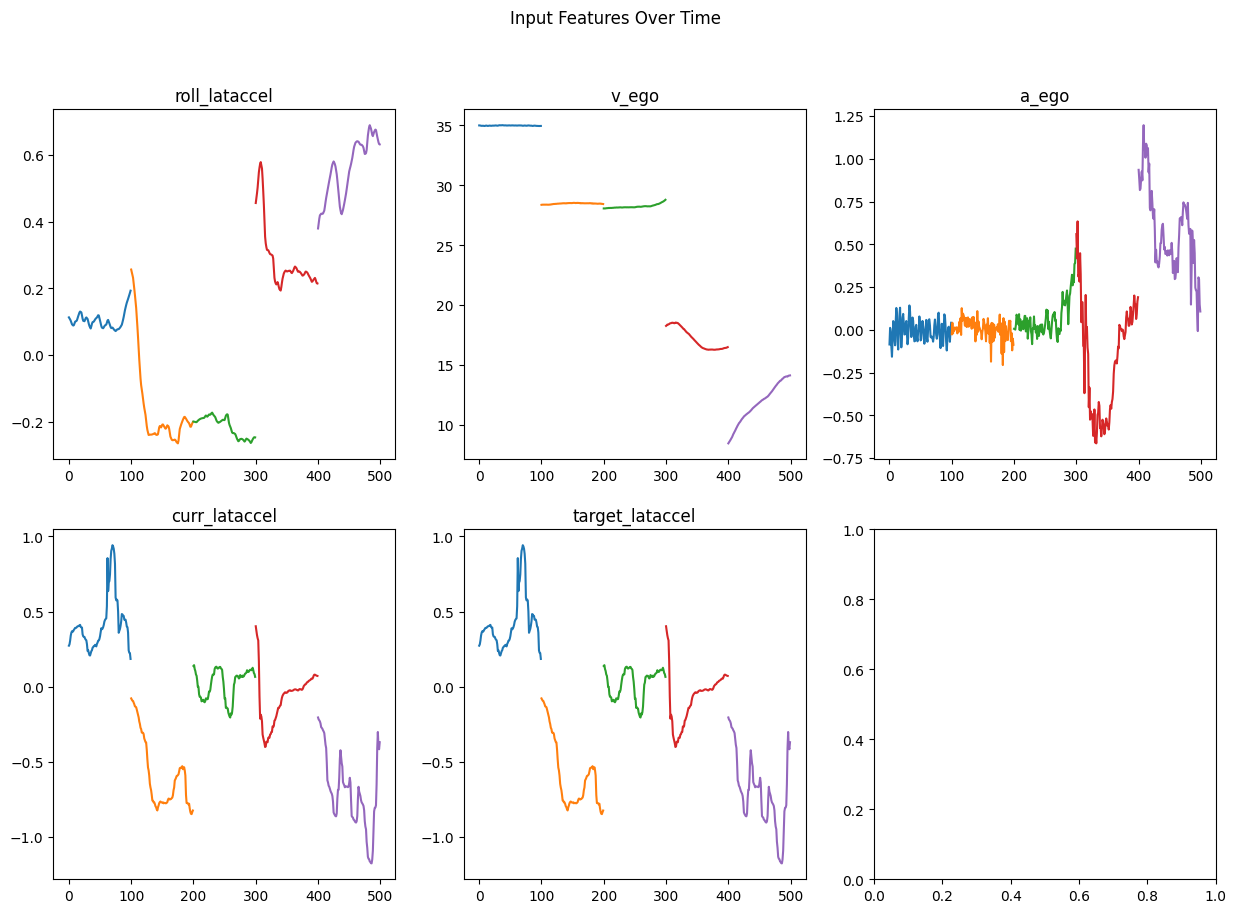

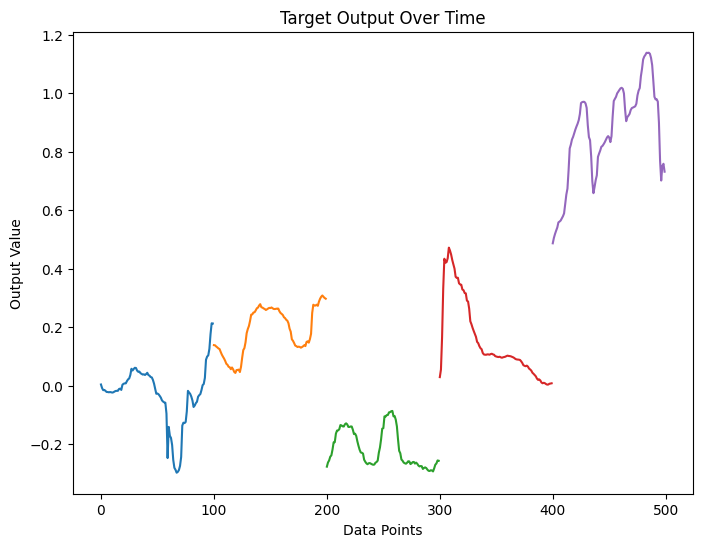

In [17]:
import matplotlib.pyplot as plt
import random 

def generate_random_list(length, min_val, max_val):
    return [random.randint(min_val, max_val) for _ in range(length)]

# Extract inputs and outputs
inputs = [d[0] for d in prepared_data]
outputs = [d[1] for d in prepared_data]

# Define the number of data points per trial
data_points_per_trial = 100

# Plot inputs over time for the first 5 groups of 100 data points
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Input Features Over Time')

selected_samples = generate_random_list(5, 0, 19999)

for i, (key, ax) in enumerate(zip(inputs[0].keys(), axs.flat)):
    ax.set_title(key)
    y = 0
    for j in selected_samples:
        start_index = j * data_points_per_trial
        end_index = (j + 1) * data_points_per_trial
        feature_values = [sample[key] for sample in inputs[start_index:end_index]]
        ax.plot(range(y * data_points_per_trial, (y + 1) * data_points_per_trial), feature_values)
        y+= 1

# Plot outputs over time for the first 5 groups of 100 data points
plt.figure(figsize=(8, 6))
plt.title('Target Output Over Time')
i = 0
for j in selected_samples:
    start_index = j * data_points_per_trial
    end_index = (j + 1) * data_points_per_trial
    plt.plot(range(i * data_points_per_trial, (i + 1) * data_points_per_trial), outputs[start_index:end_index])
    i += 1

plt.xlabel('Data Points')
plt.ylabel('Output Value')
print(selected_samples)
plt.show()


### View statistics of input and output data

In [22]:
from tabulate import tabulate

# Extract inputs and outputs
inputs = [d[0] for d in prepared_data]
outputs = [d[1] for d in prepared_data]

def pretty_stats(inputs, outputs):
    # Create a list to store the statistics
    statistics = []

    # Compute statistics for each feature
    for key in inputs[0].keys():
        feature_values = [sample[key] for sample in inputs]
        mean = np.mean(feature_values)
        std_dev = np.std(feature_values)
        min_val = np.min(feature_values)
        max_val = np.max(feature_values)
        quantiles = np.percentile(feature_values, [25, 50, 75])
        statistics.append([key, mean, std_dev, min_val, max_val, quantiles[0], quantiles[1], quantiles[2]])

    # Compute statistics for the target output
    mean_output = np.mean(outputs)
    std_dev_output = np.std(outputs)
    min_output = np.min(outputs)
    max_output = np.max(outputs)
    quantiles_output = np.percentile(outputs, [25, 50, 75])
    statistics.append(['Target Output', mean_output, std_dev_output, min_output, max_output, quantiles_output[0], quantiles_output[1], quantiles_output[2]])

    # Output the statistics in a nice table format
    headers = ["Feature", "Mean", "Std Dev", "Min", "Max", "25th Percentile", "Median (50th Percentile)", "75th Percentile"]
    print(tabulate(statistics, headers=headers, tablefmt="grid"))

pretty_stats(inputs, outputs)

+-----------------+------------+-----------+--------------+----------+-------------------+----------------------------+-------------------+
| Feature         |       Mean |   Std Dev |          Min |      Max |   25th Percentile |   Median (50th Percentile) |   75th Percentile |
+=================+============+===========+==============+==========+===================+============================+===================+
| roll_lataccel   |  0.12531   |  0.264393 |   -1.64693   |  1.6915  |        -0.0193448 |                0.163493    |         0.286703  |
+-----------------+------------+-----------+--------------+----------+-------------------+----------------------------+-------------------+
| v_ego           | 23.2602    |  9.40597  |   -0.0832909 | 42.2324  |        16.8539    |               25.9816      |        30.7407    |
+-----------------+------------+-----------+--------------+----------+-------------------+----------------------------+-------------------+
| a_ego           | 

### Normalize inputs to 0 mean and unit s.d. and visualize

In [19]:
from sklearn.preprocessing import StandardScaler

input_array = np.array([list(sample.values()) for sample in inputs])
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(input_array)

In [23]:
normalized_inputs_list = [dict(zip(inputs[0].keys(), row)) for row in normalized_inputs]

pretty_stats(normalized_inputs_list, outputs)

+-----------------+--------------+-----------+------------+-----------+-------------------+----------------------------+-------------------+
| Feature         |         Mean |   Std Dev |        Min |       Max |   25th Percentile |   Median (50th Percentile) |   75th Percentile |
+=================+==============+===========+============+===========+===================+============================+===================+
| roll_lataccel   | -2.25994e-14 |  1        |   -6.70306 |   5.92371 |        -0.547119  |                  0.14442   |          0.610429 |
+-----------------+--------------+-----------+------------+-----------+-------------------+----------------------------+-------------------+
| v_ego           | -1.55244e-13 |  1        |   -2.48178 |   2.01703 |        -0.681089  |                  0.28932   |          0.795291 |
+-----------------+--------------+-----------+------------+-----------+-------------------+----------------------------+-------------------+
| a_ego      

### Create neural network

In [55]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, c0=None):
        # If initial hidden and cell states are not provided, initialize them
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        if x.dim() == 1:
            out, (hn, cn) = self.lstm(x.unsqueeze(1), (h0, c0))
            out = self.fc(out.squeeze(1))
        else:
            out, (hn, cn) = self.lstm(x, (h0, c0))
            out = self.fc(out)
        return out, (hn, cn)

In [69]:
input_size = len(inputs[0])  # Number of input features
hidden_size = 64  # Number of hidden units
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output units

lstm_model = LSTM(input_size, hidden_size, num_layers, output_size)

input_tensor = torch.tensor(normalized_inputs, dtype=torch.float32)

# Convert outputs to PyTorch tensor
output_tensor = torch.tensor(outputs, dtype=torch.float32).view(-1, 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print(input_tensor[0:100].size())

print(input_tensor.size())
print(output_tensor.size())

torch.Size([100, 5])
torch.Size([2000000, 5])
torch.Size([2000000, 1])


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

num_epochs = 1
losses = []  # List to store loss values

for epoch in range(num_epochs):
    total_loss = 0
    hidden_state = None  # Initial hidden state
    cell_state = None    # Initial cell state

    with tqdm(range(0, len(input_tensor), DATA_POINTS_PER_FILE), desc=f'Epoch {epoch+1}/{num_epochs}', unit='file') as progress:
        for i in progress:
            input_seq = input_tensor[i:i+100]
            target_seq = input_tensor[i:i+100]

            input_seq = input_seq.unsqueeze(0)  # Add batch dimension
            target_seq = target_seq.unsqueeze(0)  # Add batch dimension

            # Reset hidden state at the beginning of each sequence
            hidden_state = None
            cell_state = None

            for j in range(input_seq.size(1)):
                curr_input_tensor = input_seq[:, j:j+1, :]
                curr_target_tensor = target_seq[:, j:j+1, :]

                # Forward pass
                output, (hidden_state, cell_state) = lstm_model(curr_input_tensor, hidden_state, cell_state)

                # Calculate loss
                loss = criterion(output, curr_target_tensor)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                total_loss += loss.item()

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()

            progress.set_postfix(loss=total_loss)

    losses.append(total_loss)  # Append loss for this epoch to the list
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

# Plot the loss over time
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
